## Test calib_opt with TC data

In [1]:
#Import general libraries
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
from climada import CONFIG
sys.path.append(str(CONFIG.local_data.func_dir))
import scClim as sc


2023-03-15 16:54:51,458 - climada.entity.exposures.base - INFO - Reading C:\Users\timo_\climada\data\exposures\litpop\LitPop_assets_pc_150arcsec_TWN\v2\LitPop_assets_pc_150arcsec_TWN.hdf5
2023-03-15 16:54:51,775 - climada.util.coordinates - INFO - Raster from resolution 0.04166665999999708 to 0.04166665999999708.


<GeoAxesSubplot:>

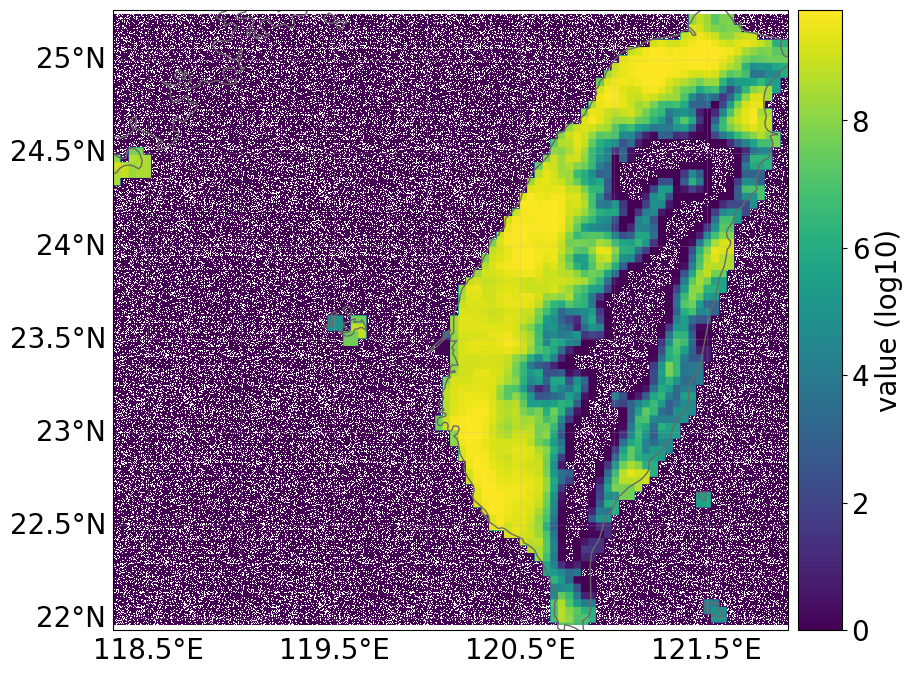

In [2]:
#load exposure Data from API
from climada.entity import LitPop
from climada.util.api_client import Client
client = Client()
TWN_nightlight = client.get_exposures('litpop', properties={'country_iso3alpha':'TWN', 'exponents': '(3,0)'})
TWN_nightlight.plot_raster()

2023-03-15 16:56:41,753 - climada.hazard.base - INFO - Reading C:\Users\timo_\climada\data\hazard\tropical_cyclone\tropical_cyclone_10synth_tracks_150arcsec_TWN_1980_2020\v2\tropical_cyclone_10synth_tracks_150arcsec_TWN_1980_2020.hdf5
Number of events: 43560
Number of events: 120


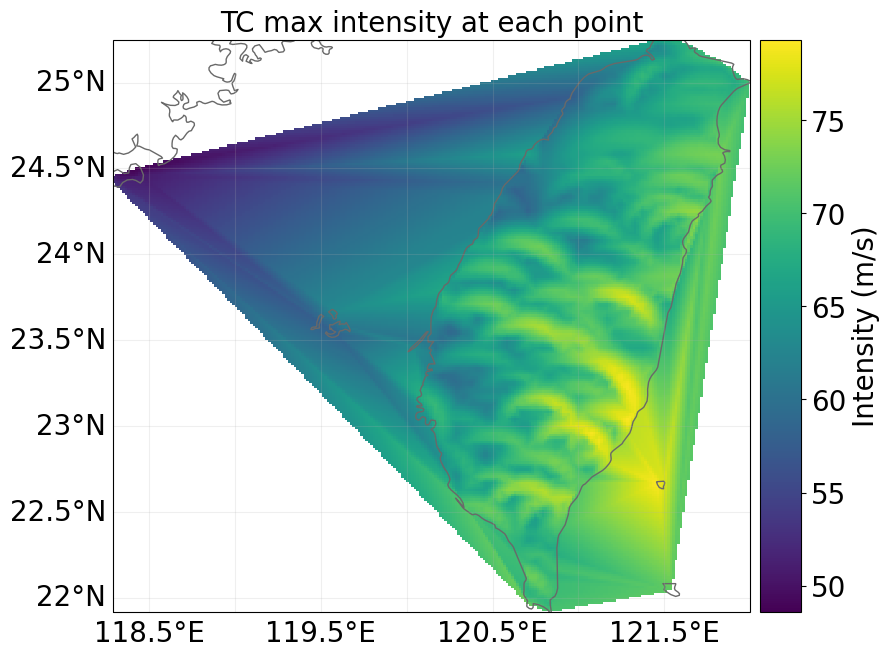

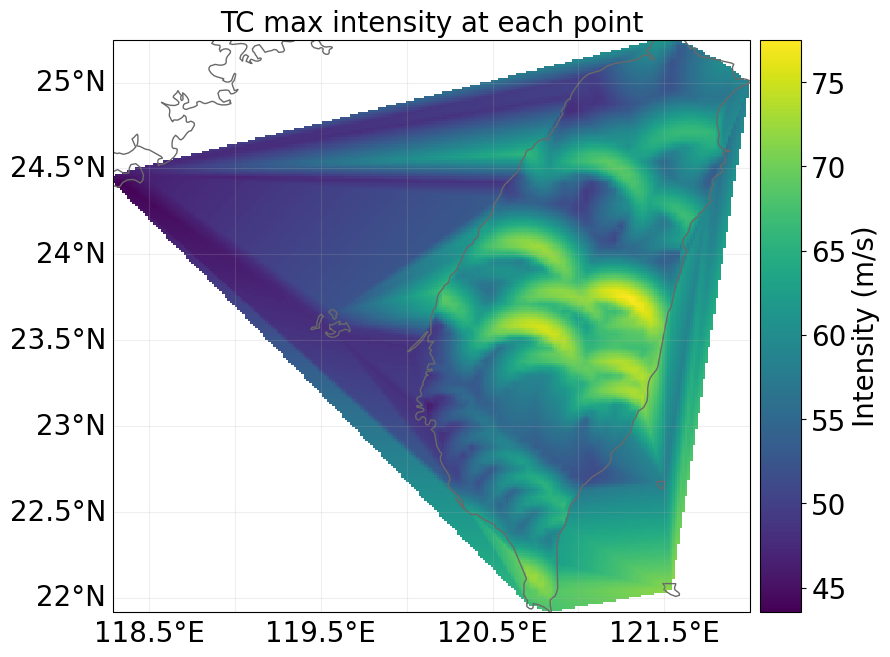

In [3]:
#Load hazard data from API and selevt 100 random events and 20 strongest events for the calibration
#THe calibration does not perform well with a high (>1000) number of events, which is anyways rarely the case
client.list_data_type_infos()
haz = client.get_hazard('tropical_cyclone',properties={'country_iso3alpha':'TWN','climate_scenario': 'historical', 'nb_synth_tracks':'10'})
haz.plot_intensity(0)
print(f'Number of events: {len(haz.event_id)}')
strongest_events = np.argsort(haz.intensity.max(axis=1).todense().getA1())[-20:]
haz = haz.select(event_id = list(np.random.choice(haz.event_id, 100, replace=False))+list(strongest_events))
haz.plot_intensity(0)
print(f'Number of events: {len(haz.event_id)}')

<AxesSubplot:title={'center':'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

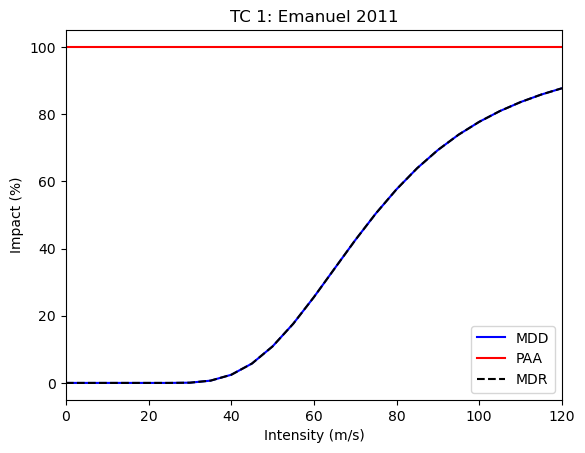

In [4]:
#Load impact function
from climada.entity import ImpactFuncSet, ImpfTropCyclone
impf = ImpfTropCyclone.from_emanuel_usa(v_thresh=25.7, v_half=74.7, scale=1)
impf_set = ImpactFuncSet()
impf_set.append(impf)
impf_set.plot()

2023-03-15 16:57:12,608 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2023-03-15 16:57:12,610 - climada.entity.exposures.base - INFO - Matching 1852 exposures with 1853 centroids.
2023-03-15 16:57:12,612 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-15 16:57:12,627 - climada.engine.impact_calc - INFO - Calculating impact for 4692 assets (>0) and 120 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

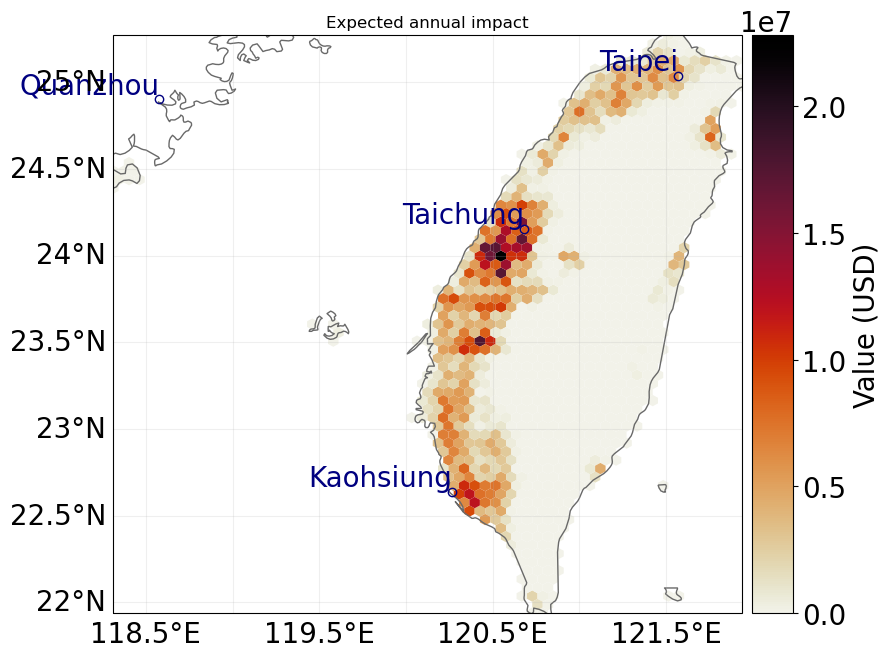

In [5]:
#Calculate impact and plot
from climada.engine import ImpactCalc
imp = ImpactCalc(TWN_nightlight,impf_set,haz).impact(save_mat=True)
imp.plot_hexbin_eai_exposure(gridsize=60,linewidths =0)

In [7]:
#define function to plot optimized and original impact functions
def plot_opt_impf(res_param, impf_orig, intensity_range,title):
    impf_opt = sc.init_impf('emanuel',res_param,intensity_range)[0]
    fig, ax = plt.subplots()
    ax.plot(impf_opt.intensity, impf_opt.mdd, label='optimized')
    ax.plot(impf_orig.intensity, impf_orig.mdd, label='initial')
    ax.legend()
    ax.set(title=title,xlabel= 'Intensity: wind speed [m/s]', ylabel='Mean damage ratio')

## Calibration with original (unperturbed) data

2023-03-15 17:10:29,584 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2023-03-15 17:10:29,585 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2023-03-15 17:10:29,586 - climada.entity.exposures.base - INFO - Matching 1852 exposures with 1853 centroids.
2023-03-15 17:10:29,587 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
|   iter    |  target   |   scale   |  v_half   | v_thresh  |
-------------------------------------------------------------
{'scale': 0.970326855112309, 'v_half': 65.66786990108668, 'v_thresh': 116.72212319578612}
| 1         | 0.0       | 0.9703    | 65.67     | 116.7     |
{'scale': 0.7433343943069282, 'v_half': 83.7274589516725, 'v_thresh': 25.930739469645165}
2023-03-15 17:10:29,602 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the

C:\Users/timo_/Documents/PhD/CLIMADA/scClim\scClim\calib_opt.py:534: RuntimeWarning: divide by zero encountered in divide
  error = 1/target


{'scale': 0.9276845401165473, 'v_half': 72.7126569770434, 'v_thresh': 26.551561336518734}


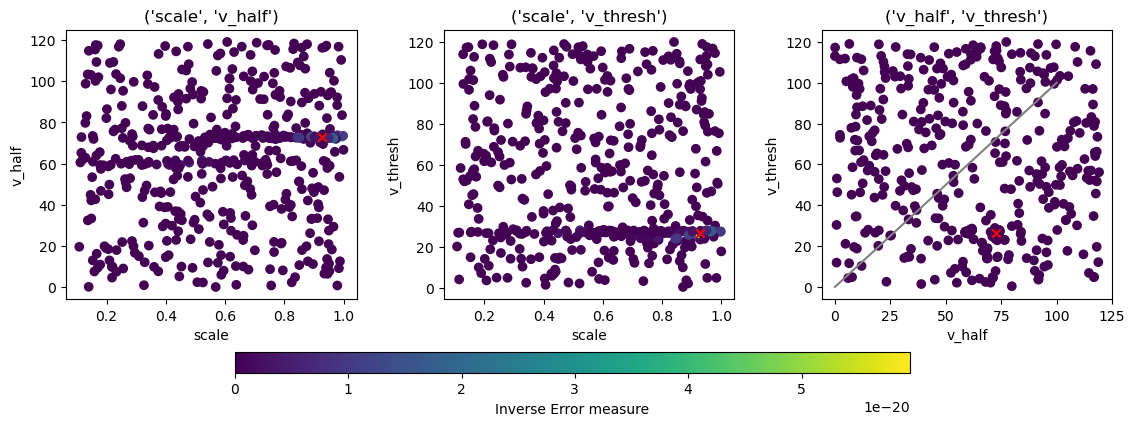

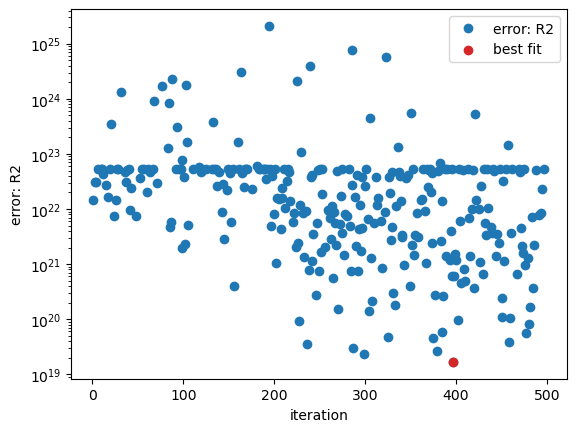

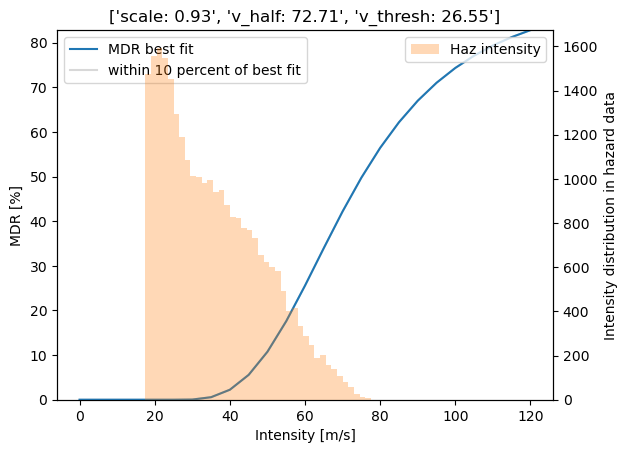

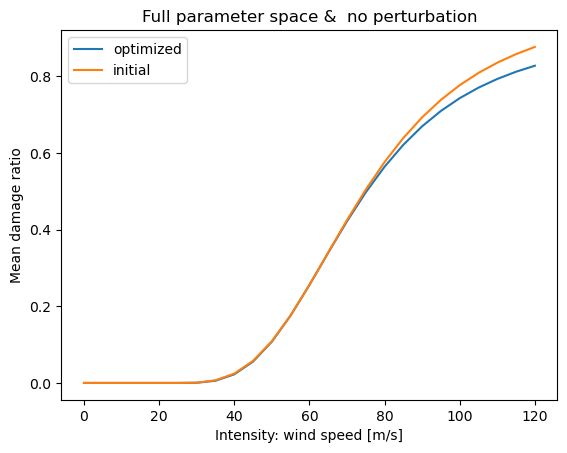

In [12]:
options = {'init_points' : 200, 'n_iter' : 300}#{'init_points' : 20, 'n_iter' : 80}
intensity_range= np.arange(0,120,1)
param_dict = {"v_thresh": 20,"v_half": 50,"scale": 0.5}
pbounds = {"v_thresh": [0,120],"v_half": [0,120],"scale": [0.1,1]}
res_param, optimizer =sc.calib_opt.calib_optimize(haz,TWN_nightlight,'emanuel',param_dict,pbounds,imp,intensity_range=intensity_range, yearly_impact=False,
                   cost_function='R2',show_details=True,options=options)
print(res_param)
plot_opt_impf(res_param, impf, intensity_range,'Full parameter space &  no perturbation')

2023-03-15 17:09:35,403 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2023-03-15 17:09:35,404 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2023-03-15 17:09:35,405 - climada.entity.exposures.base - INFO - Matching 1852 exposures with 1853 centroids.
2023-03-15 17:09:35,406 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
|   iter    |  target   |   scale   |  v_half   | v_thresh  |
-------------------------------------------------------------
{'scale': 1.0, 'v_half': 65.66786990108668, 'v_thresh': 48.63421799824422}
2023-03-15 17:09:35,421 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2023-03-15 17:09:35,423 - climada.engine.impact_calc - INFO - Calculating impact for 4692 assets (>0) and 120 events.
| 1         | 4.948e-2

C:\Users/timo_/Documents/PhD/CLIMADA/scClim\scClim\calib_opt.py:534: RuntimeWarning: divide by zero encountered in divide
  error = 1/target


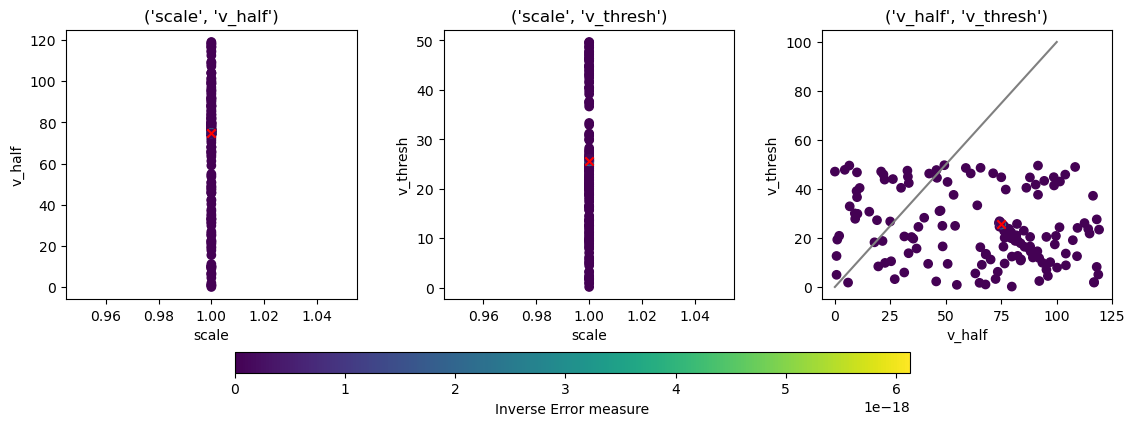

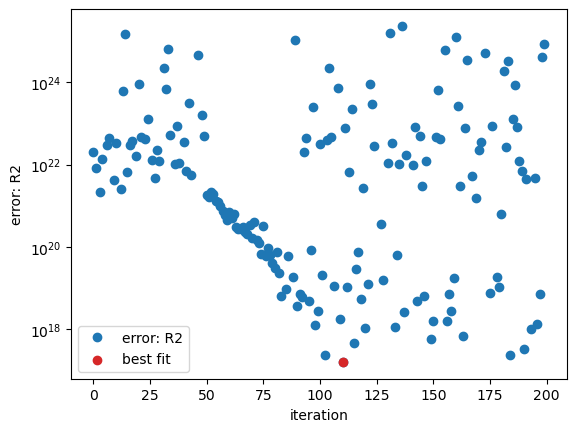

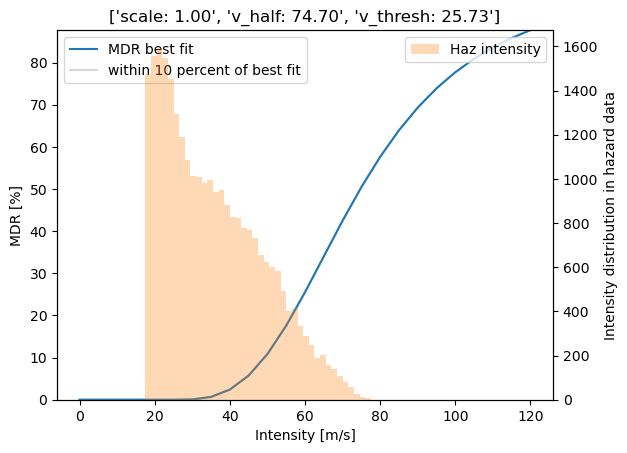

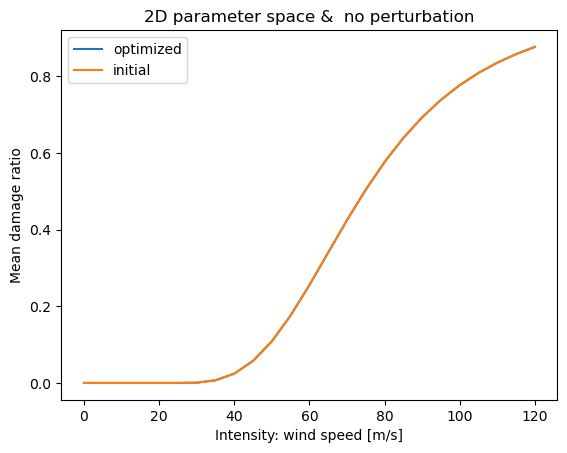

In [11]:
options = {'init_points' : 50, 'n_iter' : 150}#{'init_points' : 20, 'n_iter' : 80}
intensity_range= np.arange(0,120,1)
param_dict = {"v_thresh": 20,"v_half": 50,"scale": 1}
pbounds = {"v_thresh": [0,50],"v_half": [0,120],"scale": [1,1]}##v_thresh=25.7
res_param, optimizer =sc.calib_opt.calib_optimize(haz,TWN_nightlight,'emanuel',param_dict,pbounds,imp,intensity_range=intensity_range, yearly_impact=False,
                   cost_function='R2',show_details=True,options=options)
print(res_param)
plot_opt_impf(res_param, impf, intensity_range,'2D parameter space &  no perturbation')

## calibration with added random noise

In [8]:
import copy
imp2 = copy.deepcopy(imp)
#add random noise (20%) to impact.at_event
imp2.at_event = imp2.at_event*(1+np.random.normal(0,0.2,imp2.at_event.shape))


2023-03-15 17:02:53,563 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2023-03-15 17:02:53,565 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2023-03-15 17:02:53,566 - climada.entity.exposures.base - INFO - Matching 1852 exposures with 1853 centroids.
2023-03-15 17:02:53,568 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
|   iter    |  target   |   scale   |  v_half   | v_thresh  |
-------------------------------------------------------------
{'scale': 0.970326855112309, 'v_half': 65.66786990108668, 'v_thresh': 116.72212319578612}
| 1         | 0.0       | 0.9703    | 65.67     | 116.7     |
{'scale': 0.7433343943069282, 'v_half': 83.7274589516725, 'v_thresh': 25.930739469645165}
2023-03-15 17:02:53,586 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the

C:\Users/timo_/Documents/PhD/CLIMADA/scClim\scClim\calib_opt.py:534: RuntimeWarning: divide by zero encountered in divide
  error = 1/target


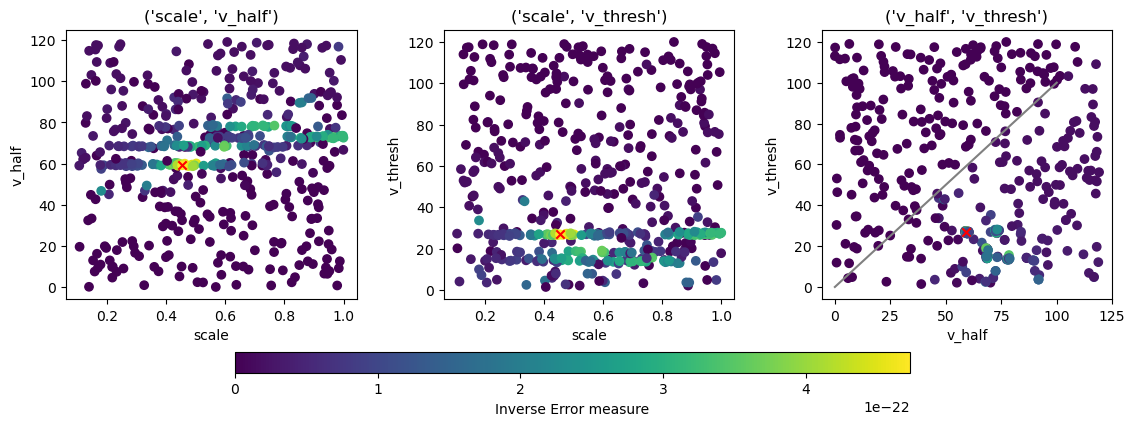

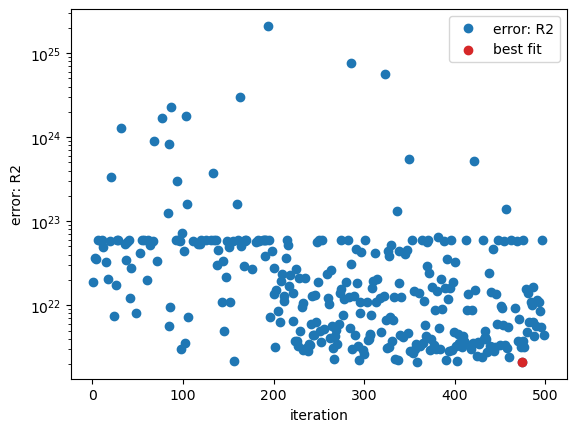

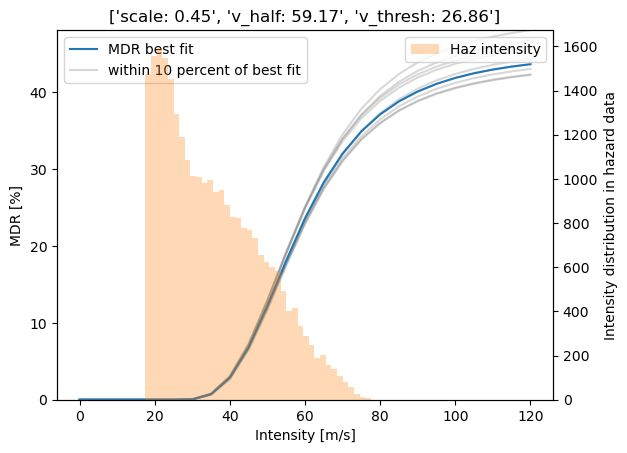

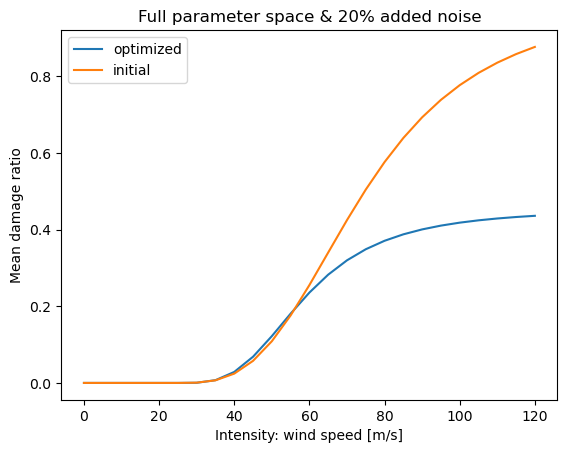

In [10]:
options = {'init_points' : 200, 'n_iter' : 300}#{'init_points' : 20, 'n_iter' : 80}
intensity_range= np.arange(0,120,1)
param_dict = {"v_thresh": 20,"v_half": 50,"scale": 0.5}
pbounds = {"v_thresh": [0,120],"v_half": [0,120],"scale": [0.1,1]}
res_param, optimizer =sc.calib_opt.calib_optimize(haz,TWN_nightlight,'emanuel',param_dict,pbounds,imp2,intensity_range=intensity_range, yearly_impact=False,
                   cost_function='R2',show_details=True,options=options)
print(res_param)
plot_opt_impf(res_param, impf, intensity_range,'Full parameter space & 20% added noise')

2023-03-15 17:01:41,457 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2023-03-15 17:01:41,458 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2023-03-15 17:01:41,459 - climada.entity.exposures.base - INFO - Matching 1852 exposures with 1853 centroids.
2023-03-15 17:01:41,462 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
|   iter    |  target   |   scale   |  v_half   | v_thresh  |
-------------------------------------------------------------
{'scale': 1.0, 'v_half': 65.66786990108668, 'v_thresh': 48.63421799824422}
2023-03-15 17:01:41,480 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2023-03-15 17:01:41,483 - climada.engine.impact_calc - INFO - Calculating impact for 4692 assets (>0) and 120 events.
| 1         | 3.493e-2

C:\Users/timo_/Documents/PhD/CLIMADA/scClim\scClim\calib_opt.py:534: RuntimeWarning: divide by zero encountered in divide
  error = 1/target


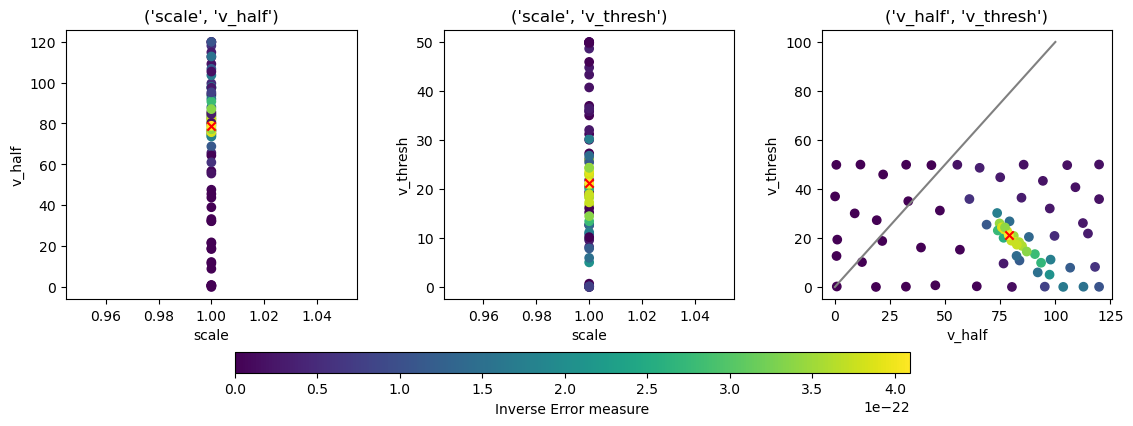

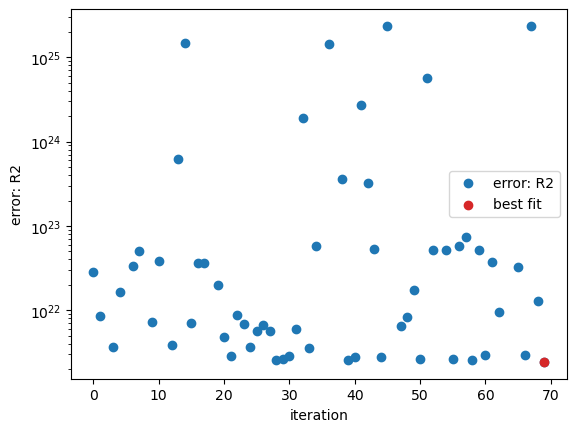

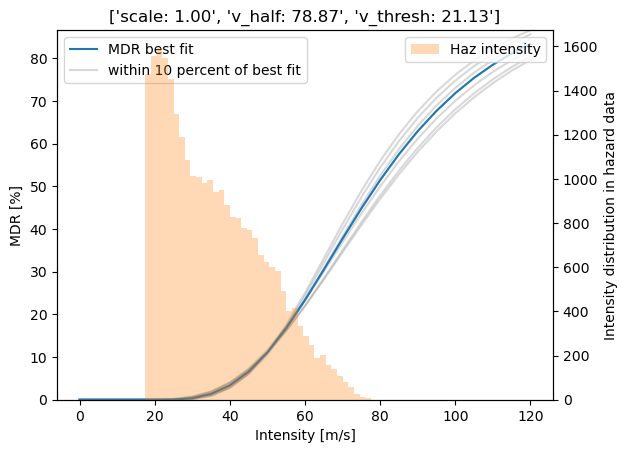

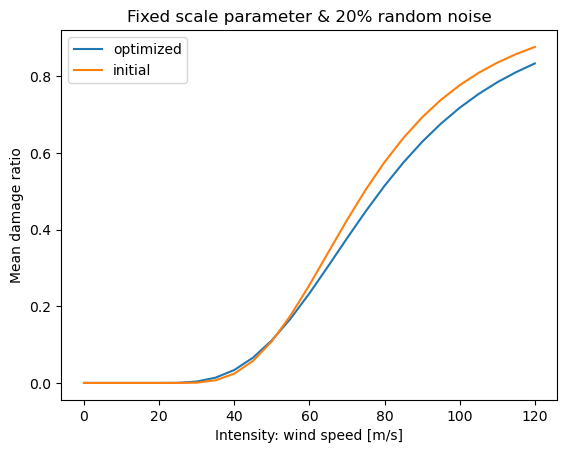

In [9]:
options = {'init_points' : 20, 'n_iter' : 50}#{'init_points' : 20, 'n_iter' : 80}
intensity_range= np.arange(0,120,1)
param_dict = {"v_thresh": 20,"v_half": 50,"scale": 1}
pbounds = {"v_thresh": [0,50],"v_half": [0,120],"scale": [1,1]}##v_thresh=25.7
res_param, optimizer =sc.calib_opt.calib_optimize(haz,TWN_nightlight,'emanuel',param_dict,pbounds,imp2,intensity_range=intensity_range, yearly_impact=False,
                   cost_function='R2',show_details=True,options=options)
print(res_param)
plot_opt_impf(res_param, impf, intensity_range,title = 'Fixed scale parameter & 20% random noise')